# Intro

This code generates all the key behavioral statistics (across session for both animals).

---
# Setup

In [1]:
##% imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from popy.io_tools import *
from popy.behavior_data_tools import *
from behav_analysis_tools import *
from popy.config import COLORS

# fontsize 12
plt.rcParams.update({'font.size': 8})


In [2]:
##% helper functions
def get_prop_event(behav_all_pd_original, column='switch'):
    """
    Calculates the proportion of events for each monkey and session, across blocks.
    """
    behav_all_pd = behav_all_pd_original.copy()

    monkeys = behav_all_pd['monkey'].unique()
    percent_selection = {monkey: [] for monkey in monkeys}

    # nominal length = 40 - blocks will be interpolated to this length
    LEN_BLOCK = 40

    # fill nans and convert to float
    behav_all_pd[column] = behav_all_pd[column].fillna(method='ffill')
    behav_all_pd[column] = behav_all_pd[column].fillna(method='bfill')
    behav_all_pd[column] = behav_all_pd[column].astype(float)  # see if its best target

    for monkey, behav_monkey in behav_all_pd.groupby('monkey'):
        for session, behav_session in behav_monkey.groupby('session'):
            for block_id, behav_block in behav_session.groupby('block_id'):
                if len(behav_block) < 35:
                    continue

                # get best target selection and shift vectors per block
                column_vector = behav_block[column]

                # interpolate to LEN_BLOCK
                column_vector = np.interp(np.linspace(0, LEN_BLOCK, LEN_BLOCK), np.linspace(0, LEN_BLOCK, len(column_vector)), column_vector)

                # append to list
                percent_selection[monkey].append(column_vector)

        # create array of best target selection
        percent_selection[monkey] = np.array(percent_selection[monkey])
        #percent_shift[monkey] = np.array(percent_shift[monkey])
        
    return percent_selection# percent_shift

def get_prop_event_advanced(behav_all_pd_original, column='switch', interpolate=True):
    """
    Calculates the proportion of events for each monkey and session, across blocks.
    """
    behav_all_pd = behav_all_pd_original.copy()
    monkeys = behav_all_pd['monkey'].unique()
    percent_selection = {monkey: [] for monkey in monkeys}

    # fill nans and convert to float
    #behav_all_pd[column] = behav_all_pd[column].fillna(method='ffill')
    #behav_all_pd[column] = behav_all_pd[column].fillna(method='bfill')
    behav_all_pd[column] = behav_all_pd[column].astype(float)  # see if its best target

    for monkey, behav_monkey in behav_all_pd.groupby('monkey'):
        for session, behav_session in behav_monkey.groupby('session'):
            percent_selection_first, percent_selection_last = [], []
            for block_id, behav_block in behav_session.groupby('block_id'):
                if len(behav_block) < 35:
                    continue

                # get best target selection and shift vectors per block
                column_vector = behav_block[column].values

                # interpolate to LEN_BLOCK
                firsts = column_vector[:35]
                lasts = column_vector[-35:]

                # append to list
                percent_selection_first.append(firsts)
                percent_selection_last.append(lasts)

            # create array of best target
            percent_selection_session = np.concatenate([percent_selection_last[:-1], percent_selection_first[1:]], axis=1)
            percent_selection[monkey].append(percent_selection_session)

        # create array of best target selection
        percent_selection[monkey] = np.concatenate(percent_selection[monkey])

    # create one array

    return percent_selection# percent_shift

def get_reward_rate_and_selected_target(behav_all_original):
    behav_all = behav_all_original.copy()
    def conv_time(t):
        dd, mm, yy = t[:2], t[2:4], t[4:6]
        date_time = np.datetime64(f'20{yy}-{mm}-{dd}')
        return date_time
        
    monkeys = behav_all.monkey.unique()
    dates = {monkey: [] for monkey in monkeys}
    reward_rates = {monkey: [] for monkey in monkeys}
    selected_target = {monkey: {1: [], 2: [], 3: []} for monkey in monkeys}

    for monkey in monkeys:
        behav_all_monkey = behav_all.loc[behav_all.monkey == monkey]
        behav_all_monkey = behav_all_monkey.sort_values('date_of_recording')

        # get measurement dates
        dates_temp = behav_all_monkey.session.unique()
        dates[monkey] = [conv_time(t) for t in dates_temp]

        # get average reward rate and selected target
        for i, session in enumerate(behav_all_monkey.session.unique()):
            session_data = behav_all_monkey.loc[behav_all_monkey.session == session]
            
            # get average reward rate
            reward_rates[monkey].append(np.mean(session_data.feedback.values))

            # get percent of target selection
            for target in [1, 2, 3]:
                avg_selection = np.mean(session_data.target == target)
                selected_target[monkey][target].append(np.mean(session_data.target == target))

    return dates, reward_rates, selected_target


In [15]:
##% plotting functions
def plot_strategy(percent_selection, percent_shift, ax=None, saveas=None):
    LEN_BLOCK = percent_selection['ka'].shape[1]
    if ax is None:
        # plotting, figsize is 130mm x 9 mm
        cm = 1/2.54  # centimeters in inches
        fig, axs = plt.subplots(1, 2, figsize=(10*cm, 4*cm))
        
    monkeys = percent_selection.keys()


    for monkey in monkeys:
        # get mean and std for best target selection and shift
        mean_best_selection = np.mean(percent_selection[monkey], axis=0)
        std_best_selection = np.std(percent_selection[monkey], axis=0)
        sem_best_selection = std_best_selection / np.sqrt(len(percent_selection[monkey]))

        mean_shift = np.mean(percent_shift[monkey], axis=0)
        std_shift = np.std(percent_shift[monkey], axis=0)
        sem_shift = std_shift / np.sqrt(len(percent_shift[monkey]))

        color = COLORS[monkey.split('_')[-1]]
        linestyle = 'dashed' if monkey.split('_')[0] == 'simulation' else 'solid'
        axs[0].plot(mean_best_selection, color=color, label=monkey.upper(), linestyle=linestyle)
        if linestyle == 'solid':
            axs[0].fill_between(np.arange(LEN_BLOCK), mean_best_selection-sem_best_selection, mean_best_selection+sem_best_selection, color=color, alpha=0.5)
        axs[1].plot(mean_shift, color=color , label=monkey.upper(), linestyle=linestyle)
        if linestyle == 'solid':
            axs[1].fill_between(np.arange(LEN_BLOCK), mean_shift-sem_shift, mean_shift+sem_shift, color=color, alpha=0.5)

    # plot settings
    ax = axs[0]
    ax.axvline(LEN_BLOCK-5, color='k', linestyle='--', alpha=0.5)
    #ax.set_title('Best target selection')
    ax.set_xlabel('Trials in block')
    ax.set_ylabel('Proportion of best\ntarget selection')
    #ax.set_ylim([0.2, 1])
    # set ticks every .2
    #ax.set_yticks(np.arange(0.2, 1.1, 0.2))
    ax.legend(loc='lower right', frameon=True)

    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax = axs[1]
    ax.axvline(LEN_BLOCK-5, color='k', linestyle='--', alpha=0.5)
    #ax.set_title('Shift')
    ax.set_xlabel('Trials in block')
    ax.set_ylabel('Probability of shift')
    #ax.set_yticks(np.arange(0, 1.1, 0.1))
    #ax.set_ylim([-0.02, .45])
    ax.legend(loc='upper right', frameon=True)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, axs


def plot_strategy_advanced(percent_selection, name_of_thingy, ax=None, saveas=None):
    if ax is None:
        # plotting, figsize is 130mm x 9 mm
        cm = 1/2.54  # centimeters in inches
        fig, axs = plt.subplots(1, 1, figsize=(10*cm, 7*cm))
        
    monkeys = percent_selection.keys()

    for monkey in monkeys:
        # get mean and std for best target selection and shift
        mean_best_selection = np.nanmean(percent_selection[monkey], axis=0)
        std_best_selection = np.nanstd(percent_selection[monkey], axis=0)
        sem_best_selection = std_best_selection / np.sqrt(len(percent_selection[monkey]))

        trial_vector = np.arange(-35, 35)
        mean_best_selection = np.convolve(mean_best_selection, np.ones(3)/3, mode='same')
        sem_best_selection = np.convolve(sem_best_selection, np.ones(3)/3, mode='same')
        axs.plot(trial_vector, mean_best_selection, color=COLORS[monkey.split('_')[0]], label=monkey.upper())
        axs.fill_between(trial_vector, mean_best_selection-sem_best_selection, mean_best_selection+sem_best_selection, color=COLORS[monkey.split('_')[0]], alpha=0.3)
        
    # plot settings
    ax = axs
    ax.axvline(-.5, color='k', linestyle='-', alpha=0.5, label='block transitions')
    ax.axvline(- 6.5, color='k', linestyle='--', alpha=0.5, label='block transition starts')
    if name_of_thingy == 'RPE':
        ax.axhline(0, color='grey', linestyle='-', alpha=0.4)

    #ax.set_title('Best target selection')
    ax.set_xlabel('Trials in block')
    ax.set_ylabel('Mean ' + name_of_thingy)
    # legend next to plot
    ax.legend(loc='upper left', frameon=True, bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlim(-10, 30)

    return fig, axs

def plot_strategy_change(dates, reward_rates, selected_target):
    monkeys = dates.keys()

    # plot
    fig, axs = plt.subplots(2, len(monkeys), figsize=(4*len(monkeys), 5))

    for i, monkey in enumerate(monkeys):
        # plot data
        axs[0, i].plot(dates[monkey], reward_rates[monkey], 'o', color='k')
        for target in [1, 2, 3]:
            axs[1, i].plot(dates[monkey], selected_target[monkey][target], marker='o', alpha=.5, label=f'target {target}')

        # plot settings
        ax = axs[0, i]
        ax.set_title(monkey)
        ax.axhline(.25, color='gray', linestyle='--')
        ax.axhline(.7, color='gray', linestyle='--')
        ax.set_ylabel('avg. reward earned')
        ax.set_ylim(.20, .75)
        # set xtick density for every 3 months, formatted as 'YY-MM'
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
        for tick in ax.get_xticklabels():
            tick.set_rotation(20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('date (yy-mm)')

        ax = axs[1, i]
        ax.set_title(monkey)
        ax.axhline(1/3, color='gray', linestyle='--')
        ax.set_ylim(-0, .8)
        ax.set_ylabel('percentage of selection (%)')
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
        for tick in ax.get_xticklabels():
            tick.set_rotation(20)
        ax.legend()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('date (yy-mm)')

    # legend
    plt.tight_layout()
    plt.show()


---
# Load data

In [4]:
# load all session data, remove those labeled as invalid
behav = load_behavior()
simulation_ka = load_simulation(monkey='ka')
simulation_po = load_simulation(monkey='po')
behav = pd.concat([behav, simulation_ka, simulation_po], ignore_index=True)

#behav = drop_time_fields(behav)
behav = add_switch_info(behav)
behav = add_shift_value(behav)
behav = add_trial_in_block(behav)
behav['trial_id_in_block'] = np.abs(behav['trial_id_in_block']-20)
#behav = add_date_of_recordig(behav)
behav = drop_time_fields(behav)
behav['if_best_target'] = behav['target'] == behav['best_target']
behav['RPE'] = behav['feedback'] - behav['shift_value']

behav

,monkey,session,trial_id,block_id,best_target,target,feedback,value_function,switch,shift_value,trial_id_in_block,if_best_target,RPE
0,ka,010720,0,0,2,3.0,1.0,NaN,NaN,0.10000,20,False,0.90000
1,ka,010720,1,0,2,3.0,0.0,NaN,0.0,0.46900,19,False,-0.46900
2,ka,010720,2,0,2,1.0,1.0,NaN,1.0,0.27671,18,False,0.72329
3,ka,010720,3,0,2,1.0,0.0,NaN,0.0,0.46900,17,False,-0.46900
4,ka,010720,4,0,2,3.0,1.0,NaN,1.0,0.27671,16,False,0.72329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78272,simulation_po,-1,15178,376,3,3.0,1.0,0.528690,0.0,NaN,19,True,NaN
78273,simulation_po,-1,15179,376,3,3.0,0.0,0.680797,0.0,NaN,20,True,NaN
78274,simulation_po,-1,15180,376,3,3.0,0.0,0.461082,0.0,NaN,21,True,NaN
78275,simulation_po,-1,15181,376,3,3.0,0.0,0.312276,0.0,NaN,22,True,NaN


---
# Statistic on strategy

In [5]:
# rename 'po' to 'po_before' and 'po_after' , depending if the date is before or after the enlightenment
'''date_of_enlightenment = np.datetime64('2021-08-01')

behav_po_split = behav.copy()
behav_po_split.loc[(behav_po_split['date_of_recording'] < np.datetime64(date_of_enlightenment) ) & (behav_po_split['monkey'] == 'po'), 'monkey'] = 'po_before'
behav_po_split.loc[(behav_po_split['date_of_recording'] >= np.datetime64(date_of_enlightenment) ) & (behav_po_split['monkey'] == 'po'), 'monkey'] = 'po_after'
behav = behav_po_split'''

# remove best_target==2 from monkey po
#`behav = behav.loc[~((behav['monkey'] == 'po') & (behav['best_target'] == 2))]

# change feedbac==1 to np.nan
#behav['feedback'] = behav['feedback'].replace(1, np.nan)
# change RPE to np.nan if feedback==1
#behav['RPE'] = behav['RPE'].where(behav['feedback'] == 0, np.nan)
behav

,monkey,session,trial_id,block_id,best_target,target,feedback,value_function,switch,shift_value,trial_id_in_block,if_best_target,RPE
0,ka,010720,0,0,2,3.0,1.0,NaN,NaN,0.10000,20,False,0.90000
1,ka,010720,1,0,2,3.0,0.0,NaN,0.0,0.46900,19,False,-0.46900
2,ka,010720,2,0,2,1.0,1.0,NaN,1.0,0.27671,18,False,0.72329
3,ka,010720,3,0,2,1.0,0.0,NaN,0.0,0.46900,17,False,-0.46900
4,ka,010720,4,0,2,3.0,1.0,NaN,1.0,0.27671,16,False,0.72329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78272,simulation_po,-1,15178,376,3,3.0,1.0,0.528690,0.0,NaN,19,True,NaN
78273,simulation_po,-1,15179,376,3,3.0,0.0,0.680797,0.0,NaN,20,True,NaN
78274,simulation_po,-1,15180,376,3,3.0,0.0,0.461082,0.0,NaN,21,True,NaN
78275,simulation_po,-1,15181,376,3,3.0,0.0,0.312276,0.0,NaN,22,True,NaN


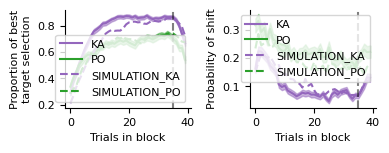

In [16]:
# get best target selection and shift vectors
percent_selection = get_prop_event(behav, 'if_best_target')
percent_shift = get_prop_event(behav, 'switch')

# plot strategy
fig, axs = plot_strategy(percent_selection, percent_shift)

# save as svg
fig.tight_layout()
fig.savefig('figs/strategy.svg', format='svg', dpi=300, transparent=True)

plt.show()
plt.close('all')


In [ ]:
behav

In [ ]:
for column in ['if_best_target', 'switch', 'feedback', 'shift_value', 'RPE']:
    percent_selection = get_prop_event_advanced(behav, column)
    fig, ax = plot_strategy_advanced(percent_selection, column)

# Evolution of strategy

In [ ]:
# get reward rates and selected target statistics over sessions
dates, reward_rates, selected_target = get_reward_rate_and_selected_target(behav)

# plot strategy change
plot_strategy_change(dates, reward_rates, selected_target)